# Import

In [1]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Conv2DTranspose
from matplotlib import pyplot
from tensorflow.keras.datasets.mnist import load_data
import numpy as np
from IPython.display import display, clear_output

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

# Descriminator

In [2]:
def define_decriminator(in_shape=(28,28,1), n_classes=10):
    in_label = Input(1,)
    li = Embedding(n_classes, 50)(in_label)
    li = Dense(in_shape[0] * in_shape[1])(li)
    li = Reshape((in_shape[0], in_shape[1], 1))(li)
    
    in_image = Input(shape=in_shape)
    
    merge = Concatenate()([in_image, li])
    
    fe = Conv2D(64, (3,3), strides=(2, 2), padding='same')(merge)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Conv2D(64, (3,3), strides=(2, 2), padding='same')(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Flatten()(fe)
    fe = Dropout(0.4)(fe)
    out_layer = Dense(1, activation='sigmoid')(fe)
    
    model = Model([in_image, in_label], out_layer)
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [3]:
d_model = define_decriminator()
d_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 50)        500         input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 1, 784)       39984       embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 28, 28, 1)]  0                                            
______________________________________________________________________________________________

# Generator

In [4]:
def define_generator(input_dim, n_classes=10):
    label_input = Input(1,)
    li = Embedding(n_classes, 50)(label_input)
    li = Dense(7 * 7)(li)
    li = Reshape((7, 7, 1))(li)
    
    noise_input = Input(shape=(input_dim,))
    gen = Dense(128 * 7 * 7)(noise_input)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Reshape((7, 7, 128))(gen)
    
    merge = Concatenate()([gen, li])
    
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge)
    gen = LeakyReLU(alpha=0.2)(gen)
    
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    
    output_layer = Conv2D(1, (7,7), activation='sigmoid', padding='same')(gen)
    
    model = Model([noise_input, label_input], output_layer)
    return model
    

In [5]:
g_model = define_generator(100, 10)
g_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 6272)         633472      input_4[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 50)        500         input_3[0][0]                    
____________________________________________________________________________________________

# Define cGan Model

In [6]:
def define_gan(generator, discriminator):
    discriminator.trainable = False
    gen_noise, gen_label = generator.input
    gen_output = generator.output
    
    gan_outpout = discriminator([gen_output, gen_label])
    
    model = Model([gen_noise, gen_label], gan_outpout)
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model 

In [7]:
gan_model = define_gan(g_model, d_model)
gan_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 6272)         633472      input_4[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 50)        500         input_3[0][0]                    
____________________________________________________________________________________________

Load sample data

In [8]:
def load_real_samples():
    (trainX, trainY), (_, _) = load_data() # load mnist dataset
    X = np.expand_dims(trainX, axis=-1) # add gray scale channel to image
    X = X.astype('float32') # convert pixel from ints to floats
    X = X / 255.0 # pixel to between
    return X, trainY

Generate random sample data

In [9]:
def generate_real_samples(dataset, n_samples):
    images, labels = dataset
    ix = np.random.randint(0, labels.shape[0], n_samples)
    X = images[ix]
    y_labels = np.expand_dims(labels[ix], axis=-1)
    y_reals = np.ones((n_samples, 1)) # mark label to 'real' as 1 
    return X, y_labels, y_reals

Gerenrate fake sample 

In [10]:
def generate_noise(noise_dim, labels):
    n_samples = len(labels)
    x_input = np.random.randn(noise_dim * n_samples) # generate random noise 
    x_input = x_input.reshape(n_samples, noise_dim)
    return x_input

In [11]:
def generate_fake_samples(noise_dim, labels):
  n_samples = len(labels)
  x_input = generate_noise(noise_dim, labels) # generate by random noise
  X = g_model.predict([x_input, labels]) # generate image from our model
  y_fake = np.zeros((n_samples, 1)) # mark label to 'fake' as 0
  return X, labels, y_fake

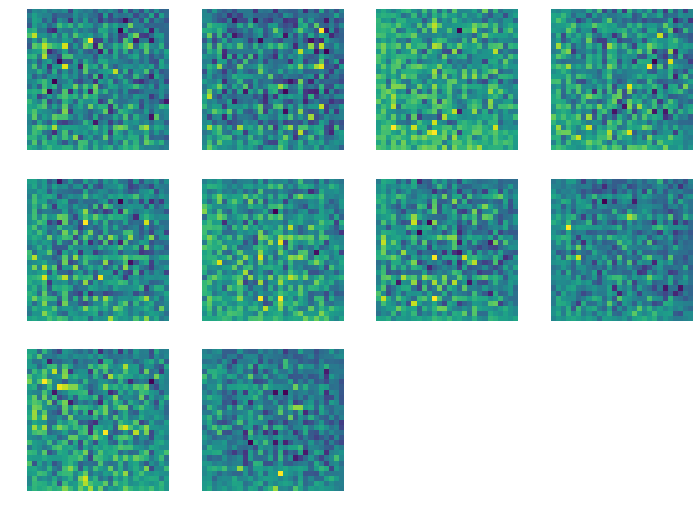

In [12]:
fig = pyplot.figure(figsize=(12, 12))
X, _, _ = generate_fake_samples(100, np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))
for i in range(10):
    pyplot.subplot(4, 4, 1 + i)
    pyplot.axis('off')
    pyplot.imshow(X[i, :, :, 0])
    pyplot.draw()


# Training

In [13]:
dataset = load_real_samples()
n_epochs=500
batch_size=128
half_batch = int(batch_size / 2)
steps = int(dataset[0].shape[0] / batch_size)
noise_dim = 100

11493376/11490434 [==============================] - 0s 0us/step


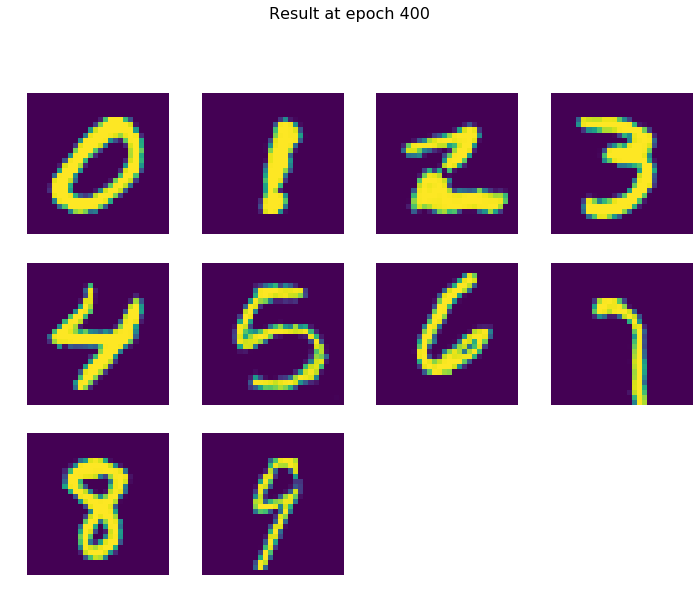

In [14]:
fig = pyplot.figure(figsize=(12, 12))
axs = []
for i in range(10):
    axs.append(pyplot.subplot(4, 4, 1 + i))
    
for epoch in range(n_epochs):
    for step in range(steps):
        X_real, real_labels, y_real = generate_real_samples(dataset, half_batch)
        X_fake, fake_labels, y_fake = generate_fake_samples(100, real_labels)
        y = np.vstack((y_real, y_fake))
        labels = np.vstack((real_labels, fake_labels))
        X = np.vstack((X_real, X_fake))

        d_loss, d_acurracy = d_model.train_on_batch([X, labels], y)

        x_gan = generate_noise(noise_dim, labels)
        y_gan = np.ones((batch_size, 1))
        gan_model.train_on_batch([x_gan, labels], y_gan)

    if epoch % 100 == 0: # evaluate every 100 epochs
        fake_test, _, _ = generate_fake_samples(100, np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))
        fig.suptitle('Result at epoch {}'.format(epoch), fontsize=16)
        for i in range(10):
            ax = axs[i]
            ax.cla()
            ax.axis('off')
            ax.imshow(fake_test[i, :, :, 0])
        fig.savefig("result_at_epoch_{}.png".format(epoch))
        display(fig)
        clear_output(wait = True) 

# See our result

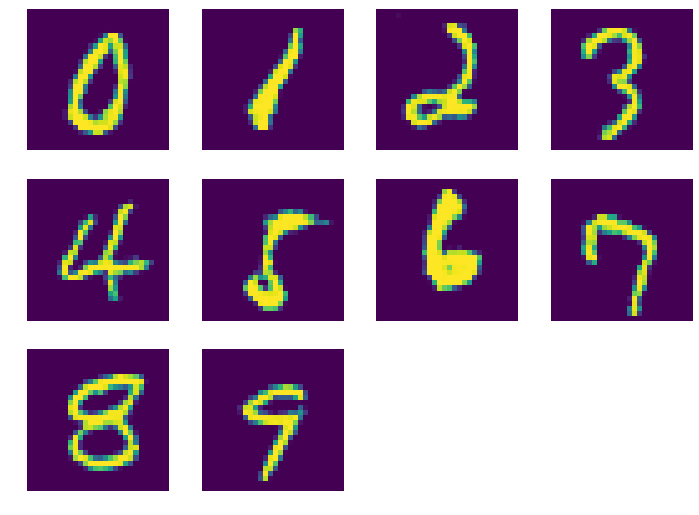

In [15]:
fig = pyplot.figure(figsize=(12, 12))
fake_result, _, _ = generate_fake_samples(100, np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))
for i in range(10):
    pyplot.subplot(4, 4, 1 + i)
    pyplot.axis('off')
    pyplot.imshow(fake_result[i, :, :, 0])
    pyplot.draw()

We can see we just train our model only 500 epochs but we can generate better result and Normal Gan [here](https://www.kaggle.com/uysimty/get-start-with-gan)